# Sarcasm Detection on SARC / sarcasm_v2 dataset using GRU and LSTM

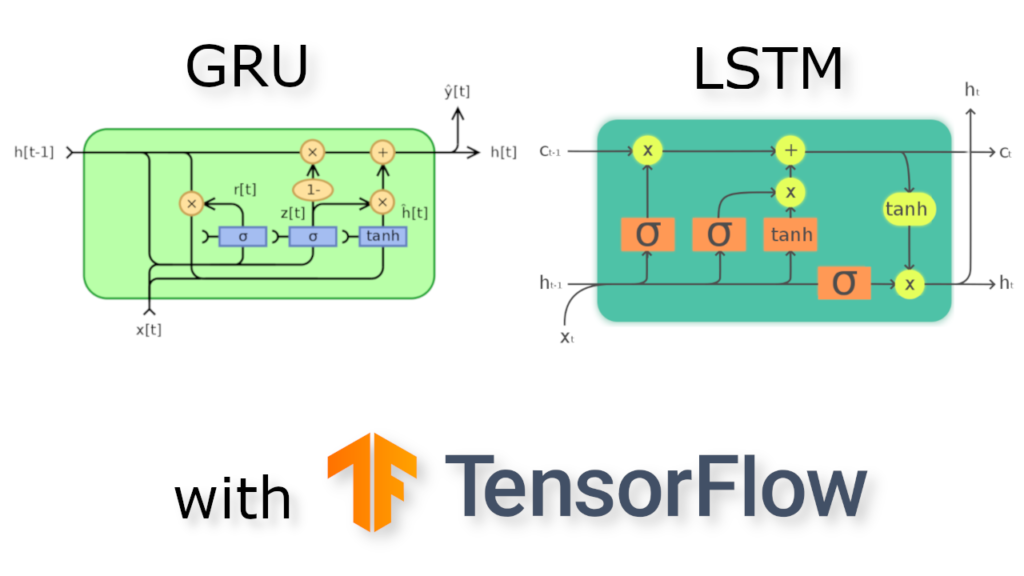

### Prepare Dataset
 * Go to https://drive.google.com/drive/folders/1dzF__PeMXuGq29NSbLbvvHV5hE6dlz5J?usp=sharing
 * Download train-balanced-sarcasm.csv
 * In Google Drive, create a folder named `Sarcasm_Detection` and keep the sarcasm_v2 folder inside that.
 * The path for the dataset should be `drive/My Drive/Sarcasm_Detection/sarcasm_v2/`

*Notes:*
* The original SARC dataset: https://nlp.cs.princeton.edu/old/SARC/2.0/main/
* Pre-processed and clean dataset (collected): https://www.kaggle.com/datasets/danofer/sarcasm?resource=download&select=train-balanced-sarcasm.csv (large)
* Small sarcasm v2 dataset: `sarcasm_v2/*` https://nlds.soe.ucsc.edu/sarcasm2

In [ ]:
import warnings
warnings.filterwarnings("ignore")

#### Install dependencies

In [ ]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 27.6 MB/s eta 0:00:00


##### Load dataset from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Datasets
* We can use 4 datasets. To change a dataset we just have to replace the SARC_dataset_path string to the corresponding dataset path.
* First make sure, you download https://drive.google.com/drive/folders/1dzF__PeMXuGq29NSbLbvvHV5hE6dlz5J?usp=sharing the `Sarcasm_Detection` folder and upload to your Google drive.

*The datasets are:*
 * `SARC_dataset_path = "drive/My Drive/Sarcasm_Detection/sarcasm_v2/GEN-sarc-notsarc.csv"`
 * `SARC_dataset_path = "drive/My Drive/Sarcasm_Detection/sarcasm_v2/HYP-sarc-notsarc.csv"`
 * `SARC_dataset_path = "drive/My Drive/Sarcasm_Detection/sarcasm_v2/RQ-sarc-notsarc.csv"`
 * `SARC_dataset_path = "drive/My Drive/Sarcasm_Detection/train-balanced-sarcasm.csv"`

In [ ]:
SARC_dataset_path = "drive/My Drive/Sarcasm_Detection/sarcasm_v2/GEN-sarc-notsarc.csv"

In [ ]:
import pandas as pd
SARC_df = pd.read_csv(SARC_dataset_path)

In [ ]:
SARC_df.head()

,class,id,text
0,notsarc,1,"If that's true, then Freedom of Speech is doom..."
1,notsarc,2,Neener neener - is it time to go in from the p...
2,notsarc,3,"Just like the plastic gun fear, the armour pie..."
3,notsarc,4,So geology is a religion because we weren't he...
4,notsarc,5,Well done Monty. Mark that up as your first ev...


* We are only looking at `text`, and `class` column. 
* (train sentences, and groundtruth)

In [ ]:
set(SARC_df['class'])

{'notsarc', 'sarc'}

In [ ]:
dataset_x = SARC_df['text']
dataset_y = SARC_df['class']

In [ ]:
dataset_y.replace({'notsarc': 0, 'sarc': 1}, inplace = True)

In [ ]:
dataset_y

0       0
1       0
2       0
3       0
4       0
       ..
6515    1
6516    1
6517    1
6518    1
6519    1
Name: class, Length: 6520, dtype: int64

In [ ]:
from collections import Counter
Counter(dataset_y)

Counter({0: 3260, 1: 3260})

 * 75% data for training and 25% for testing / validation / evaluation.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset_x, dataset_y, test_size=0.25, random_state=42)

In [ ]:
X_train, X_test, y_train, y_test = list(X_train), list(X_test), list(y_train), list(y_test)

In [ ]:
print(len(X_train))
print(len(X_test))

4890
1630


 * For tokenizing text to numbers / tokens, we are just going to use **BertTokenizer**.

Introduction 
Tokenization is one of the first step in any NLP pipeline. Tokenization is nothing but splitting the raw text into small chunks of words or sentences, called tokens. If the text is split into words, then its called as 'Word Tokenization' and if it's split into sentences then its called as 'Sentence Tokenization'. Generally 'space' is used to perform the word tokenization and characters like 'periods, exclamation point and newline char are used for Sentence Tokenization. We have to choose the appropriate method as per the task in hand. While performing the tokenization few characters like spaces, punctuations are ignored and will not be the part of final list of tokens.

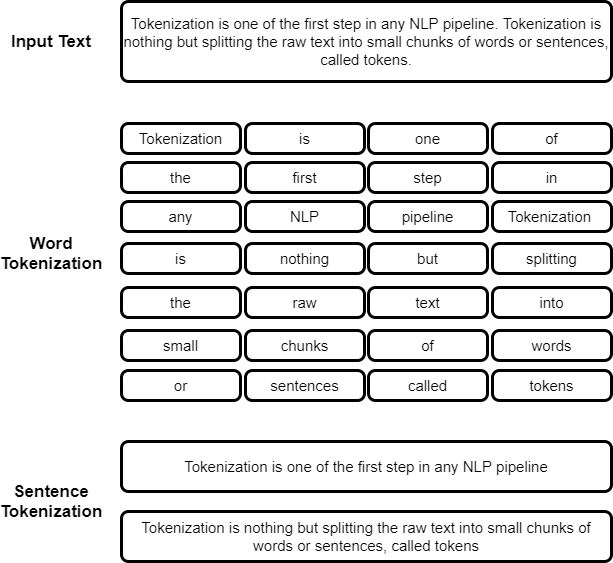

Why Tokenization is Required? 
Every sentence gets its meaning by the words present in it. So by analyzing the words present in the text we can easily interpret the meaning of the text. Once we have a list of words we can also use statistical tools and methods to get more insights into the text. For example, we can use word count and word frequency to find out important of word in that sentence or document.

#### Summary of sentence length overall

In [ ]:
import numpy as np
print(np.mean([len(x.split(' ')) for x in X_train]))
print(np.max([len(x.split(' ')) for x in X_train]))
print(np.min([len(x.split(' ')) for x in X_train]))

43.7398773006135
164
9


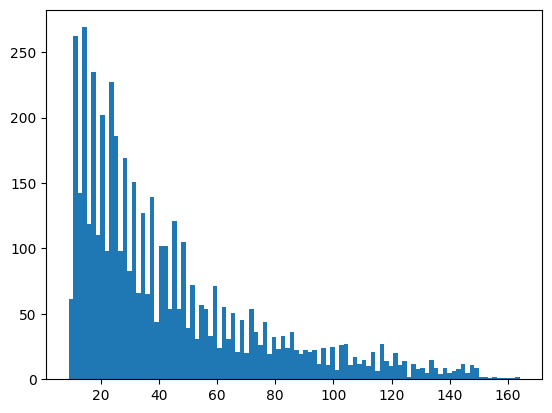

In [ ]:
import matplotlib.pyplot as plt
plt.hist([len(x.split(' ')) for x in X_train], bins = 100)
plt.show()

### Drop all the sentences longer than 30 

In [ ]:
X_cp = []
y_cp = []
for i, xt in enumerate(dataset_x):
  if len(xt.split(' ')) <= 50 and len(xt.split(' ')) >= 5:
    X_cp.append(dataset_x[i])
    y_cp.append(dataset_y[i])

In [ ]:
X_ds = X_cp.copy()
y_ds = y_cp.copy()

In [ ]:
print(f"New dataset lengh :: {len(X_ds)}")

New dataset lengh :: 4594


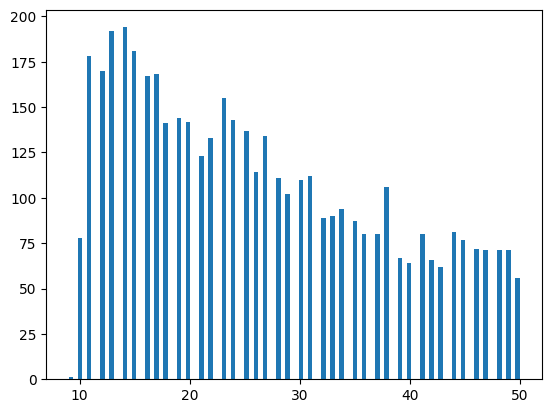

In [ ]:
plt.hist([len(x.split(' ')) for x in X_ds], bins = 100)
plt.show()

### Tutorials for text tokenization
* https://www.kaggle.com/code/satishgunjal/tokenization-in-nlp
* https://neptune.ai/blog/tokenization-in-nlp
* https://www.analyticsvidhya.com/blog/2021/09/an-explanatory-guide-to-bert-tokenizer/

In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_ds)

X_token = tokenizer.texts_to_sequences(X_ds)

vocab_size = len(tokenizer.word_index) + 1

In [ ]:
print(vocab_size)

12113


In [ ]:
print(X_ds[0])
print(tokenizer.texts_to_sequences([X_ds[0]]))

If that's true, then Freedom of Speech is doomed. Harassment is subjective. Now I can claim that a book I don't like is harassing me, and it will be banned.
[[23, 89, 159, 58, 499, 5, 566, 8, 2090, 2978, 8, 2091, 93, 9, 40, 226, 6, 4, 342, 9, 33, 45, 8, 5711, 50, 7, 10, 59, 17, 944]]


In [ ]:
from keras.utils import pad_sequences
maxlen = 50
X_pad = pad_sequences(X_token, padding='post', maxlen=maxlen)

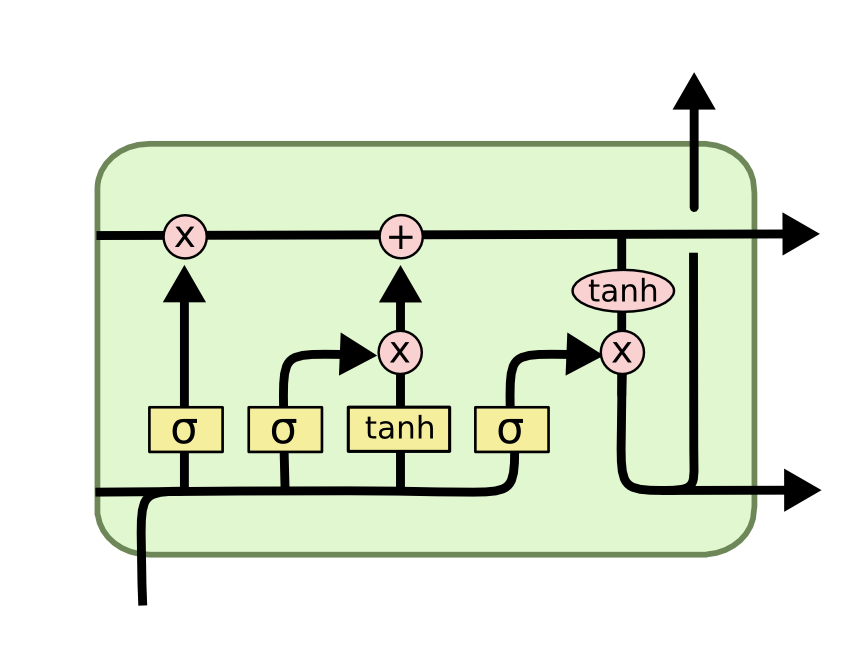

### Long short-term memory
Long short-term memory (LSTM) is an artificial neural network used in the fields of artificial intelligence and deep learning. Unlike standard feedforward neural networks, LSTM has feedback connections.

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, CuDNNLSTM, Bidirectional, Dense, Dropout

embedding_dim = 8

model = Sequential()
model.add(Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(Bidirectional(CuDNNLSTM(100, return_sequences = True)))
model.add(Dropout(0.3))
model.add(Bidirectional(CuDNNLSTM(100)))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', recall_m, precision_m, f1_m])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 8)             96904     
                                                                 
 bidirectional (Bidirectiona  (None, 50, 200)          88000     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 50, 200)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              241600    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense (Dense)               (None, 1)                 2

In [ ]:
len(dataset_y)

6520

#### Learning rate scheduler

In [ ]:
import keras
def lr_scheduler(epoch, lr):
    decay_rate = 0.5
    decay_step = 2
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

callbacks = [
    keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
]

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

y_ds = np.array(y_ds)
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=0)
sss.get_n_splits(X_pad, y_ds)

#print(sss)       

for train_index, test_index in sss.split(X_pad, y_ds):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X_pad[train_index], X_pad[test_index]
    y_train, y_test = y_ds[train_index], y_ds[test_index]

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=15,
                    verbose=1,
                    validation_split=0.2,
                    batch_size=256,
                    callbacks=callbacks)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/15
11/11 [==============================] - 14s 298ms/step - loss: 0.6796 - accuracy: 0.5809 - recall_m: 0.9821 - precision_m: 0.5702 - f1_m: 0.7192 - val_loss: 0.6810 - val_accuracy: 0.5661 - val_recall_m: 1.0000 - val_precision_m: 0.5647 - val_f1_m: 0.7217 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/15
11/11 [==============================] - 2s 213ms/step - loss: 0.6748 - accuracy: 0.5859 - recall_m: 0.9844 - precision_m: 0.5907 - f1_m: 0.7375 - val_loss: 0.6729 - val_accuracy: 0.5801 - val_recall_m: 0.9749 - val_precision_m: 0.5751 - val_f1_m: 0.7233 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0005000000237487257.
Epoch 3/15
11/11 [==============================] - 3s 281ms/step - loss: 0.6647 - accuracy: 0.6104 - recall_m: 0.9704 - precision_m: 0.6218 - f1_m: 0.7565 - val_loss: 0.6676 - val_accuracy: 0.5972 - v

#### Building an LSTM model for Text Classification

In [ ]:
model.evaluate(X_test, y_test)

44/44 [==============================] - 0s 9ms/step - loss: 0.6710 - accuracy: 0.6635 - recall_m: 0.7944 - precision_m: 0.6881 - f1_m: 0.7339


[0.6709809899330139,
 0.6635242700576782,
 0.7943974137306213,
 0.6881357431411743,
 0.7338597774505615]

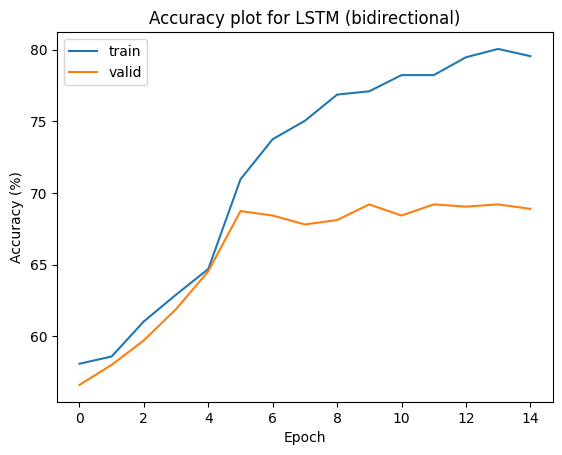

In [ ]:
plt.plot(np.array(history.history['accuracy']) * 100.)
plt.plot(np.array(history.history['val_accuracy']) * 100.)
plt.legend(['train', 'valid'])
plt.title('Accuracy plot for LSTM (bidirectional)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.show()

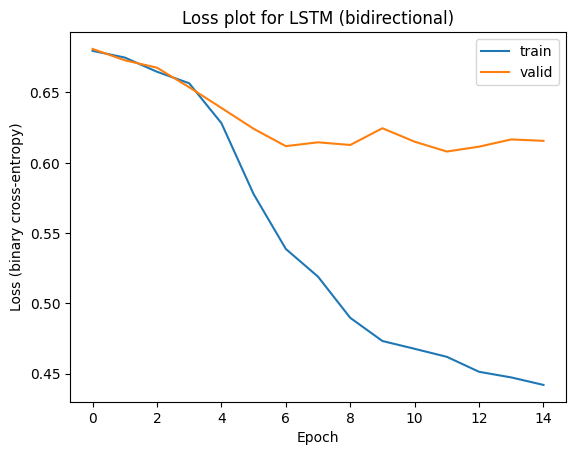

In [ ]:
plt.plot(np.array(history.history['loss']))
plt.plot(np.array(history.history['val_loss']))
plt.legend(['train', 'valid'])
plt.title('Loss plot for LSTM (bidirectional)')
plt.xlabel('Epoch')
plt.ylabel('Loss (binary cross-entropy)')
plt.show()

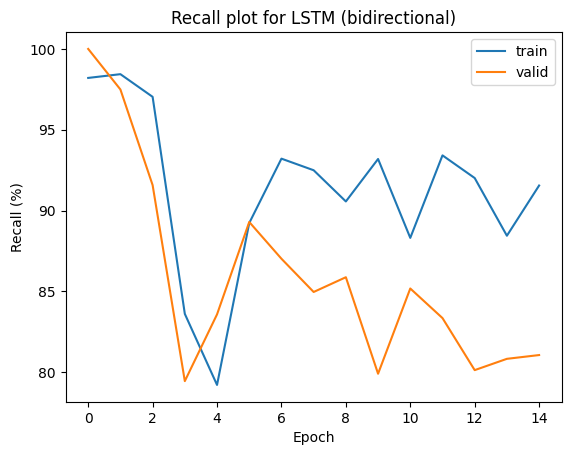

In [ ]:
plt.plot(np.array(history.history['recall_m']) * 100.)
plt.plot(np.array(history.history['val_recall_m']) * 100.)
plt.legend(['train', 'valid'])
plt.title('Recall plot for LSTM (bidirectional)')
plt.xlabel('Epoch')
plt.ylabel('Recall (%)')
plt.show()

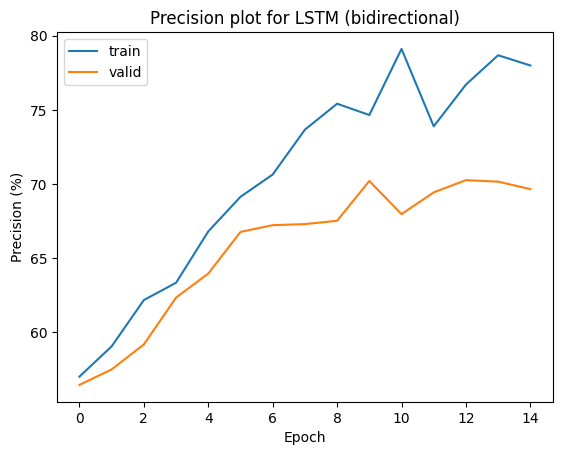

In [ ]:
plt.plot(np.array(history.history['precision_m']) * 100.)
plt.plot(np.array(history.history['val_precision_m']) * 100.)
plt.legend(['train', 'valid'])
plt.title('Precision plot for LSTM (bidirectional)')
plt.xlabel('Epoch')
plt.ylabel('Precision (%)')
plt.show()

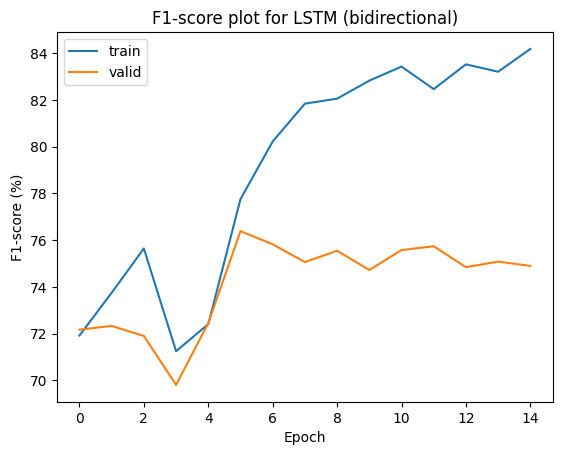

In [ ]:
plt.plot(np.array(history.history['f1_m']) * 100.)
plt.plot(np.array(history.history['val_f1_m']) * 100.)
plt.legend(['train', 'valid'])
plt.title('F1-score plot for LSTM (bidirectional)')
plt.xlabel('Epoch')
plt.ylabel('F1-score (%)')
plt.show()

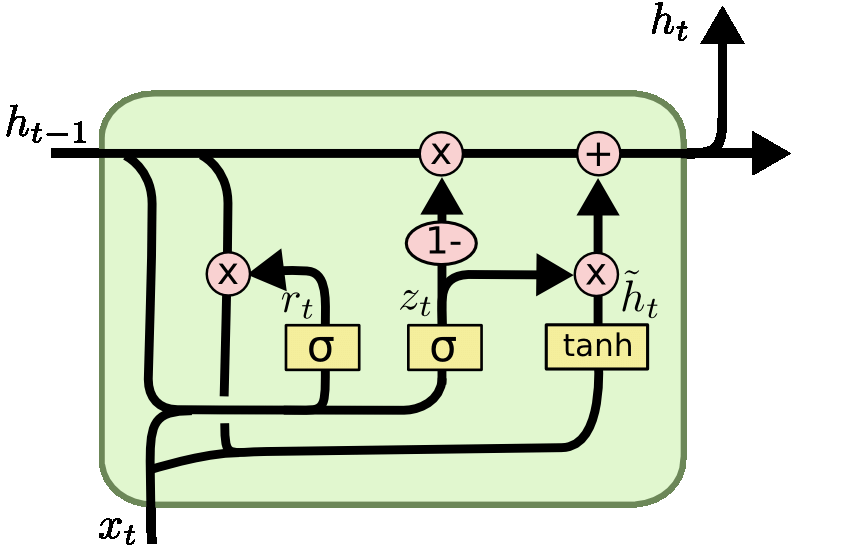

### Gated recurrent unit
Gated Recurrent Unit (GRU) is a type of recurrent neural network (RNN) that was introduced by Cho et al. in 2014 as a simpler alternative to Long Short-Term Memory (LSTM) networks. Like LSTM, GRU can process sequential data such as text, speech, and time-series data.

The basic idea behind GRU is to use gating mechanisms to selectively update the hidden state of the network at each time step. The gating mechanisms are used to control the flow of information in and out of the network. The GRU has two gating mechanisms, called the reset gate and the update gate.

The reset gate determines how much of the previous hidden state should be forgotten, while the update gate determines how much of the new input should be used to update the hidden state. The output of the GRU is calculated based on the updated hidden state.

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, CuDNNGRU, Bidirectional, Dense

embedding_dim = 8

model = Sequential()
model.add(Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(Bidirectional(CuDNNGRU(128, return_sequences = True)))
model.add(Dropout(0.3))
model.add(Bidirectional(CuDNNGRU(128))) 
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', recall_m, precision_m, f1_m])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 8)             96904     
                                                                 
 bidirectional_4 (Bidirectio  (None, 50, 256)          105984    
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 50, 256)           0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 256)              296448    
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=1,
                    validation_split=0.2,
                    batch_size=256,
                    callbacks=callbacks)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/10
11/11 [==============================] - 8s 381ms/step - loss: 0.6814 - accuracy: 0.5828 - recall_m: 0.9641 - precision_m: 0.5795 - f1_m: 0.7203 - val_loss: 0.6849 - val_accuracy: 0.5661 - val_recall_m: 1.0000 - val_precision_m: 0.5647 - val_f1_m: 0.7217 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/10
11/11 [==============================] - 2s 218ms/step - loss: 0.6754 - accuracy: 0.5855 - recall_m: 1.0000 - precision_m: 0.5709 - f1_m: 0.7253 - val_loss: 0.6804 - val_accuracy: 0.5661 - val_recall_m: 1.0000 - val_precision_m: 0.5647 - val_f1_m: 0.7217 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0005000000237487257.
Epoch 3/10
11/11 [==============================] - 2s 187ms/step - loss: 0.6687 - accuracy: 0.5863 - recall_m: 1.0000 - precision_m: 0.5508 - f1_m: 0.7006 - val_loss: 0.6746 - val_accuracy: 0.5677 - va

In [ ]:
model.evaluate(X_test, y_test)

44/44 [==============================] - 0s 9ms/step - loss: 0.6377 - accuracy: 0.6853 - recall_m: 0.6958 - precision_m: 0.7227 - f1_m: 0.7039


[0.6376675367355347,
 0.6852791905403137,
 0.6958107948303223,
 0.7227157354354858,
 0.7038955092430115]

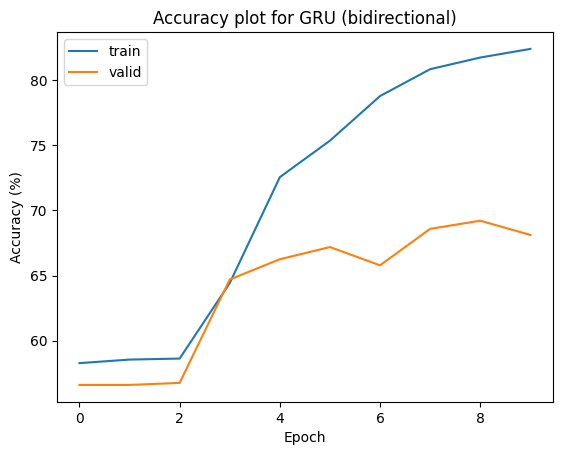

In [ ]:
plt.plot(np.array(history.history['accuracy']) * 100.)
plt.plot(np.array(history.history['val_accuracy']) * 100.)
plt.legend(['train', 'valid'])
plt.title('Accuracy plot for GRU (bidirectional)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.show()

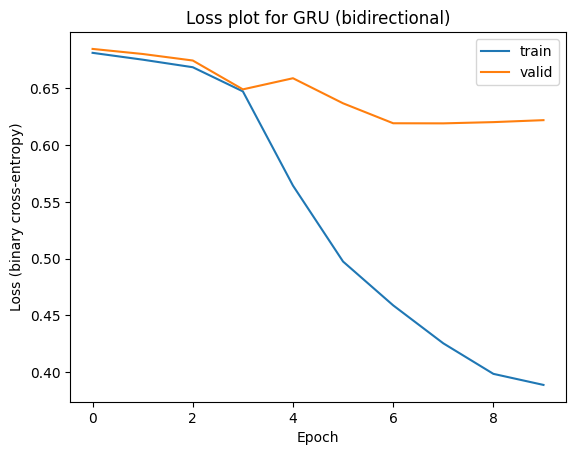

In [ ]:
plt.plot(np.array(history.history['loss']))
plt.plot(np.array(history.history['val_loss']))
plt.legend(['train', 'valid'])
plt.title('Loss plot for GRU (bidirectional)')
plt.xlabel('Epoch')
plt.ylabel('Loss (binary cross-entropy)')
plt.show()

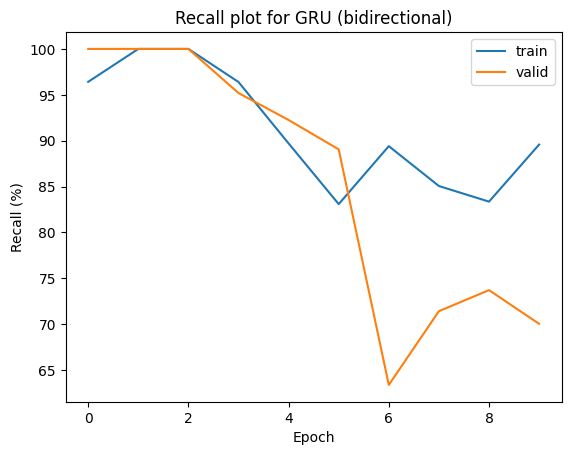

In [ ]:
plt.plot(np.array(history.history['recall_m']) * 100.)
plt.plot(np.array(history.history['val_recall_m']) * 100.)
plt.legend(['train', 'valid'])
plt.title('Recall plot for GRU (bidirectional)')
plt.xlabel('Epoch')
plt.ylabel('Recall (%)')
plt.show()

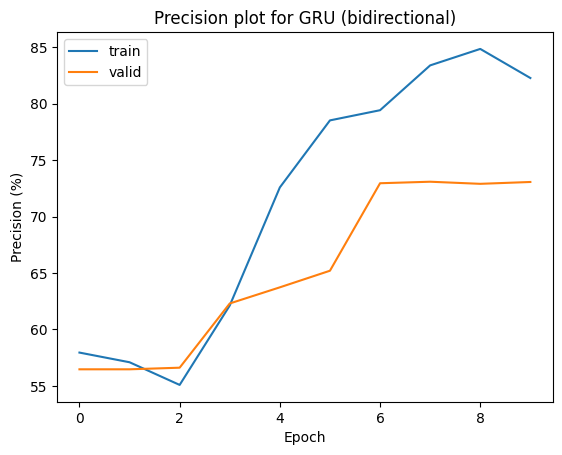

In [ ]:
plt.plot(np.array(history.history['precision_m']) * 100.)
plt.plot(np.array(history.history['val_precision_m']) * 100.)
plt.legend(['train', 'valid'])
plt.title('Precision plot for GRU (bidirectional)')
plt.xlabel('Epoch')
plt.ylabel('Precision (%)')
plt.show()

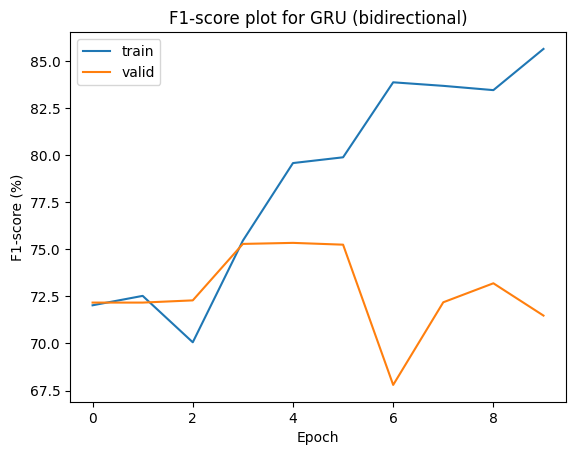

In [ ]:
plt.plot(np.array(history.history['f1_m']) * 100.)
plt.plot(np.array(history.history['val_f1_m']) * 100.)
plt.legend(['train', 'valid'])
plt.title('F1-score plot for GRU (bidirectional)')
plt.xlabel('Epoch')
plt.ylabel('F1-score (%)')
plt.show()